In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [346]:
args = {}
args['dim_h'] = 32            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 10               # number of dimensions in latent space. -- might need to bump this up? not sure what's common for MNIST
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 10           # hyper param for weight of discriminator loss
args['lr'] = 0.0002           # learning rate for Adam optimizer
args['epochs'] = 5           # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD

In [347]:
## load MNIST data train and test sets
trainset = datasets.MNIST(
    root='./data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

testset = datasets.MNIST(
    root='./data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

train_loader = DataLoader(
    dataset=trainset,
    batch_size=args['batch_size'],
    shuffle=True
)

test_loader = DataLoader(
    dataset=testset,
    batch_size=args['batch_size'],
    shuffle=False
)

## Try out the vanilla autoencoder 

In [348]:
## create encoder model and decoder model
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        self.conv = nn.Sequential(
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.dim_h * 8),
            nn.ReLU(True),
        )
        
        # final layer is fully connected
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        x = x.squeeze()
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 8 * 7 * 7),
            nn.ReLU()
        )

        # deconvolutional filters, essentially the inverse of convolutional filters
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4),
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4),
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, 1, 4, stride=2),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 8, 7, 7)
        x = self.deconv(x)
        return x

In [349]:
# instantiate models, and set to train mode
encoder, decoder = Encoder(args), Decoder(args)
encoder.train()
decoder.train()

# specify loss (mean squared error of image reconstruction)
criterion = nn.MSELoss()

# use the Adam optimizer, it's always a good choice
enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

In [350]:
%%time

for epoch in range(args['epochs']):
    step = 0

    for images, _ in tqdm(train_loader):
        encoder.zero_grad()
        decoder.zero_grad()
        batch_size = images.size()[0]

        z_real = encoder(images)
        x_recon = decoder(z_real)
        recon_loss = criterion(x_recon, images)

        recon_loss.backward()
        
        enc_optim.step()
        dec_optim.step()
        
        step += 1

        if (step + 1) % 100 == 0:
            print("Epoch: [%d/%d], Step: [%d/%d], Reconstruction Loss: %.4f" %
                  (epoch + 1, args['epochs'], step + 1, len(train_loader), recon_loss.data.item()))
            


 42%|████▏     | 99/235 [06:45<08:22,  3.70s/it]

Epoch: [1/5], Step: [100/235], Reconstruction Loss: 0.0884



 85%|████████▍ | 199/235 [12:51<01:56,  3.23s/it]

Epoch: [1/5], Step: [200/235], Reconstruction Loss: 0.0509



100%|██████████| 235/235 [15:04<00:00,  3.02s/it]

 42%|████▏     | 99/235 [06:50<07:51,  3.46s/it]

Epoch: [2/5], Step: [100/235], Reconstruction Loss: 0.0365



 85%|████████▍ | 199/235 [12:00<01:39,  2.77s/it]

Epoch: [2/5], Step: [200/235], Reconstruction Loss: 0.0317



100%|██████████| 235/235 [13:40<00:00,  2.30s/it]

 42%|████▏     | 99/235 [04:38<06:46,  2.99s/it]

Epoch: [3/5], Step: [100/235], Reconstruction Loss: 0.0270



 85%|████████▍ | 199/235 [09:35<01:50,  3.07s/it]

Epoch: [3/5], Step: [200/235], Reconstruction Loss: 0.0230



100%|██████████| 235/235 [11:23<00:00,  2.50s/it]

 42%|████▏     | 99/235 [06:35<10:01,  4.43s/it]

Epoch: [4/5], Step: [100/235], Reconstruction Loss: 0.0213



 85%|████████▍ | 199/235 [12:40<02:31,  4.20s/it]

Epoch: [4/5], Step: [200/235], Reconstruction Loss: 0.0195



100%|██████████| 235/235 [15:13<00:00,  3.83s/it]

 42%|████▏     | 99/235 [06:02<09:46,  4.31s/it]

Epoch: [5/5], Step: [100/235], Reconstruction Loss: 0.0171



 85%|████████▍ | 199/235 [11:39<01:40,  2.80s/it]

Epoch: [5/5], Step: [200/235], Reconstruction Loss: 0.0155



100%|██████████| 235/235 [13:18<00:00,  2.29s/it]


CPU times: user 2h 10min 10s, sys: 4min 55s, total: 2h 15min 6s
Wall time: 1h 8min 40s


## Let's look at some images

In [387]:
train_loader.dataset.train_data.shape

torch.Size([60000, 28, 28])

In [83]:
plot_samples[0,0,:,:] = images[ind,0].numpy()

In [ ]:
def computeTSNEProjectionOfLatentSpace(X, encoder, display=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    X_encoded = encoder.predict(X)

    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded)

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots()
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.6)
        plt.show()
    else:
        return X_tsne

In [367]:
from sklearn import manifold

def computeTSNEProjectionOfLatentSpace(X, encoder, display=True):
    # Compute latent space representation
    print("Computing latent space projection...")
    X_encoded = encoder(X)

    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X_encoded.detach().numpy())

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots()
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.6)
        plt.show()
    else:
        return X_tsne

In [376]:
def computeTSNEProjectionOfPixelSpace(X, display=True):
    # Compute t-SNE embedding of latent space
    print("Computing t-SNE embedding...")
    tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
    X_tsne = tsne.fit_transform(X.reshape([-1,28*28*1]))

    # Plot images according to t-sne embedding
    if display:
        print("Plotting t-SNE visualization...")
        fig, ax = plt.subplots()
        imscatter(X_tsne[:, 0], X_tsne[:, 1], imageData=X, ax=ax, zoom=0.6)
        plt.show()
    else:
        return X_tsne

In [369]:
X_tsne = computeTSNEProjectionOfLatentSpace(images, encoder, display=False)

Computing latent space projection...
Computing t-SNE embedding...


In [372]:
images.shape

torch.Size([96, 1, 28, 28])

In [371]:
X_tsne.shape

(96, 2)

In [ ]:
%%time

X_tsne_pix = computeTSNEProjectionOfPixelSpace(images, display=False)

Computing t-SNE embedding...


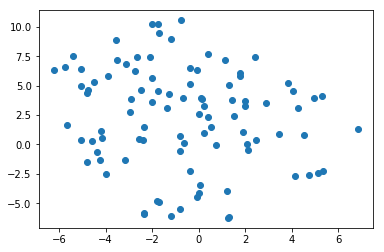

In [379]:
plt.scatter(X_tsne_pix[:,0], X_tsne_pix[:,1])

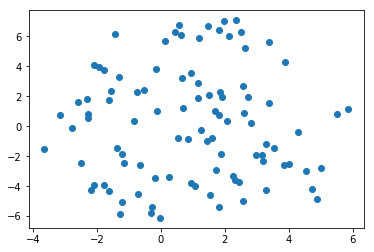

In [370]:
plt.scatter(X_tsne[:,0], X_tsne[:,1])

In [351]:
def plot_reconstructions(encoder, decoder, model_title, 
                         samp_size=10, seed=100, 
                         optimizer_name="adam"):
    
    # set seed
    np.random.seed(seed)

    # define sampling parameters
    max_ind = images.shape[0]

    # generate sample
    indices = np.random.randint(0, max_ind, size=samp_size)

    # generate decoded images for plotting
    z_reps = encoder(images)
    decoded_images = decoder(z_reps)

    # plot results
    fig, axes = plt.subplots(2, samp_size, figsize=(10.5,2.5))

    plt.suptitle("MNIST Sampled Training Images (top row)\n"\
                 "vs. {0} Reconstructions (bottom-row)".format(model_title), 
                 fontsize=15)

    for ax, ind in zip(axes[0],indices):
        ax.imshow(images[ind,0].numpy())
        ax.axis("off")
    for ax, ind in zip(axes[1],indices):
        ax.imshow(decoded_images[ind,0].detach().numpy())
        ax.axis("off")
    
    # add footnote with relevant model parameters
    figtext_text = "latent dimension size: {0} / hidden layer size: {1} "\
                "/ epochs: {2} / batch size: {3}\n"\
                "optimizer: {4} / learning rate: {5}".format(encoder.n_z, 
                                                             encoder.dim_h, 
                                                             args["epochs"],
                                                             args["batch_size"], 
                                                             optimizer_name, 
                                                             args["lr"])

    plt.figtext(.5, 0.01, figtext_text, fontsize=12, va="center", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0, top=0.78)
    plt.show()

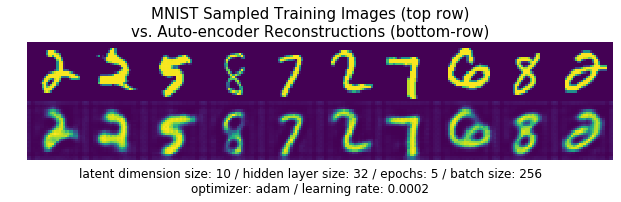

In [352]:
plot_reconstructions(encoder, decoder, "Auto-encoder", seed=100)

In [353]:
def plot_interpolation(encoder, decoder, model_title, 
                       start_index, end_index,
                       interp_steps=10, seed=100, 
                       optimizer_name="adam"):
    
    # set seed
    np.random.seed(seed)

    # define sampling parameters
    max_ind = images.shape[0]

    # generate sample
    indices = np.random.randint(0, max_ind, size=samp_size)

    # generate decoded images for plotting
    z_reps = encoder(images)
    decoded_images = decoder(z_reps)

    # plot results
    fig, axes = plt.subplots(2, interp_steps, figsize=(10.5,2.5))

    plt.suptitle("MNIST Sampled Training Images (top row)\n"\
                 "vs. {0} Reconstructions (bottom-row)".format(model_title), 
                 fontsize=15)
    

    start = images[start_index,0].numpy()
    end = images[end_index,0].numpy()
    diff = end - start
    lin_step_size = diff/interp_steps
    
    images_trans.data = images.clone()

    for ax in axes[0]:
        ax.imshow(start)
        ax.axis("off")
        start += lin_step_size
    for ax in axes[1]:
        int_rep = encoder(images_trans)
        latent_trans = decoder(int_rep)
        plt.imshow(latent_trans[start_index,0].detach().numpy())
        ax.axis("off")
        images_trans += torch.tensor(lin_step_size)
    
    # add footnote with relevant model parameters
    figtext_text = "latent dimension size: {0} / hidden layer size: {1} "\
                "/ epochs: {2} / batch size: {3}\n"\
                "optimizer: {4} / learning rate: {5}".format(encoder.n_z, 
                                                             encoder.dim_h, 
                                                             args["epochs"],
                                                             args["batch_size"], 
                                                             optimizer_name, 
                                                             args["lr"])

    plt.figtext(.5, 0.01, figtext_text, fontsize=12, va="center", ha="center")

    plt.subplots_adjust(wspace=0, hspace=0, top=0.78)
    plt.show()

UnboundLocalError: local variable 'images_trans' referenced before assignment

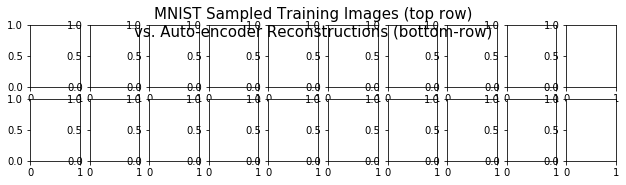

In [354]:
plot_interpolation(encoder, decoder, "Auto-encoder", 1, 2, seed=100)

args = {}
args['dim_h'] = 32            # factor controlling size of hidden layers
args['n_channel'] = 1         # number of channels in the input data (MNIST is 1, aka greyscale)
args['n_z'] = 10               # number of dimensions in latent space. -- might need to bump this up? not sure what's common for MNIST
args['sigma'] = 1.0           # variance in n_z
args['lambda'] = 10           # hyper param for weight of discriminator loss
args['lr'] = 0.0002           # learning rate for Adam optimizer
args['epochs'] = 5           # how many epochs to run for
args['batch_size'] = 256      # batch size for SGD

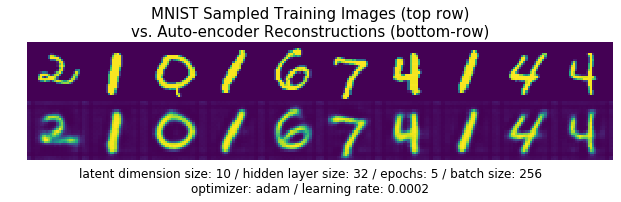

In [197]:
# set seed
np.random.seed(100)

# define sampling parameters
max_ind = images.shape[0]
samp_size = 10

# create 4D array for storing sample images
# plot_samples = np.full((5,2,28,28),0)

# generate sample
indices = np.random.randint(0, max_ind, size=samp_size)

# # store sample train images in array
# for i, ind in enumerate(indices):
#     plot_samples[i,0] = images[ind,0].numpy()

# generate decoded images for plotting
z_reps = encoder(images)
decoded_images = decoder(z_reps)

# plot results
fig, axes = plt.subplots(2, samp_size, figsize=(10.5,2.5))

plt.suptitle("MNIST Sampled Training Images (top row)\n"\
             "vs. Auto-encoder Reconstructions (bottom-row)", 
             fontsize=15)

for ax, ind in zip(axes[0],indices):
    ax.imshow(images[ind,0].numpy())
    ax.axis("off")
for ax, ind in zip(axes[1],indices):
    ax.imshow(decoded_images[ind,0].detach().numpy())
    ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0, top=0.78)

figtext_text = "latent dimension size: {0} / hidden layer size: {1} "\
                "/ epochs: {2} / batch size: {3}\n"\
                "optimizer: {4} / learning rate: {5}".format(encoder.n_z, 
                                                             encoder.dim_h, 
                                                             args["epochs"],
                                                             args["batch_size"], 
                                                             "adam", 
                                                             args["lr"])

plt.figtext(.5, 0.01, figtext_text, fontsize=12, va="center", ha="center")

plt.show()

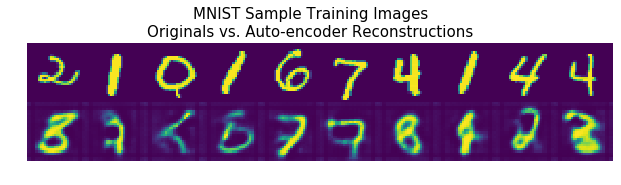

In [165]:
# set seed
np.random.seed(100)

# define sampling parameters
max_ind = images.shape[0]
samp_size = 10

# create 4D array for storing sample images
plot_samples = np.full((5,2,28,28),0)

# generate sample
indices = np.random.randint(0, max_ind, size=samp_size)

# # store sample train images in array
# for i, ind in enumerate(indices):
#     plot_samples[i,0] = images[ind,0].numpy()

# generate decoded images for plotting
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

# plot results
fig, axes = plt.subplots(2, samp_size, figsize=(10.5,2.5))

plt.suptitle("MNIST Sample Training Images\n"\
             "Originals vs. Auto-encoder Reconstructions", 
             fontsize=15)

for ax, ind in zip(axes[0],indices):
    ax.imshow(images[ind,0].numpy())
    ax.axis("off")
for ax, ind in zip(axes[1],indices):
    ax.imshow(rand_decoded_images[ind,0].detach().numpy())
    ax.axis("off")

plt.subplots_adjust(wspace=0, hspace=0, top=0.78)
# plt.tight_layout()
plt.show()

In [316]:
images_trans = images.clone()

In [317]:
images_trans += images_trans

In [51]:
np.random.randint(0, max_ind, size=samp_size)

array([73, 86, 58, 43, 50])

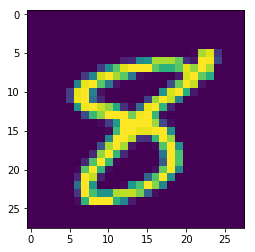

In [344]:
# look at an original image
plt.imshow(images[2,0].numpy())

In [247]:
test_array = np.zeros((1,1,28,28))

In [265]:
test_array[0,0] = images[1,0]
torch.tensor(test_array).shape

torch.Size([1, 1, 28, 28])

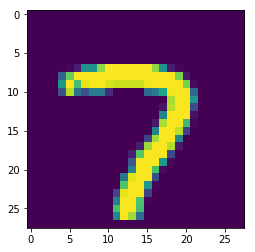

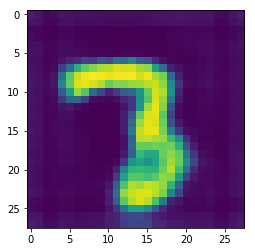

In [363]:
lin_steps = 10

start = images[1,0].numpy()
end = images[2,0].numpy()
diff = end - start
lin_step_size = diff/10

pixel_trans = start + lin_step_size*10
z_rep = encoder(images + torch.tensor(lin_step_size)*10)
latent_trans = decoder(z_rep)

plt.imshow(pixel_trans)
plt.show()
plt.imshow(latent_trans[1,0].detach().numpy())
plt.show()

In [229]:
(images[2,0].numpy()[5] - images[1,0].numpy()[5] )

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.09411765, -0.5686275 , -1.        ,
       -0.95686275, -0.3764706 , -0.00784314,  0.        ,  0.        ,
        0.        ,  0.01568628,  0.8666667 ,  0.9529412 ,  0.15294118,
        0.        ,  0.        ,  0.        ], dtype=float32)

In [228]:
print(images[2,0].numpy()[5])
print(images[1,0].numpy()[5])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01568628 0.8666667  0.9529412
 0.15294118 0.         0.         0.        ]
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.09411765 0.5686275  1.         0.95686275 0.3764706  0.00784314
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


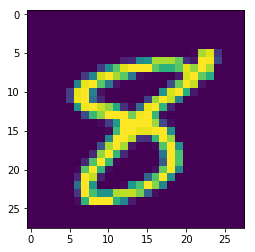

In [284]:
plt.imshow(images[2,0].numpy())

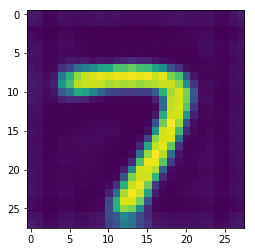

In [364]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[2,0].detach().numpy())

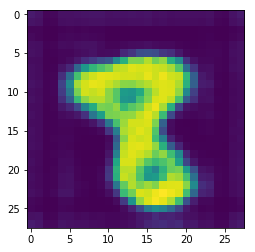

In [360]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[2,0].detach().numpy())

## WAE-GAN!

In [13]:
# define the descriminator
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # main body of discriminator, returns [0,1]
        self.main = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, self.dim_h * 4),
            nn.ReLU(True),
            nn.Linear(self.dim_h * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.main(x)
        return x
    
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

In [14]:
# instantiate discriminator model, and restart encoder and decoder, for fairness. Set to train mode, etc
encoder, decoder, discriminator = Encoder(args), Decoder(args), Discriminator(args)
encoder.train()
decoder.train()
discriminator.train()

enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])
dis_optim = torch.optim.Adam(discriminator.parameters(), lr = args['lr'])

In [ ]:
one = torch.Tensor([1])

for epoch in range(args['epochs']):
    step = 0

    for images, _ in tqdm(train_loader):
        encoder.zero_grad()
        decoder.zero_grad()
        discriminator.zero_grad()

        # ======== Train Discriminator ======== #
        
        # freeze auto encoder params
        frozen_params(decoder)
        frozen_params(encoder)
        
        # free discriminator params
        free_params(discriminator)

        # run discriminator against randn draws
        z_fake = torch.randn(images.size()[0], args['n_z']) * args['sigma']
        d_fake = discriminator(z_fake)

        # run discriminator against encoder z's
        z_real = encoder(images)
        d_real = discriminator(z_real)

        # formula for ascending the descriminator -- -one reverses the direction of the gradient.
        torch.log(d_fake).mean().backward(-one)
        torch.log(1 - d_real).mean().backward(-one)

        dis_optim.step()

        # ======== Train Generator ======== #

        # flip whose frozen, whose not
        free_params(decoder)
        free_params(encoder)
        frozen_params(discriminator)

        batch_size = images.size()[0]

        # run images
        z_real = encoder(images)
        x_recon = decoder(z_real)
        
        # discriminate latents
        d_real = discriminator(encoder(images.data))

        # calculate reconstruction loss
        recon_loss = criterion(x_recon, images)
        
        # calculate discriminator loss
        d_loss = args['lambda'] * (torch.log(d_real)).mean()

        recon_loss.backward(one)
        d_loss.backward(-one)

        enc_optim.step()
        dec_optim.step()

        step += 1

        if (step + 1) % 100 == 0:
            print("Epoch: [%d/%d], Step: [%d/%d], Reconstruction Loss: %.4f" %
                (epoch + 1, args['epochs'], step + 1, len(train_loader), recon_loss.data.item()))

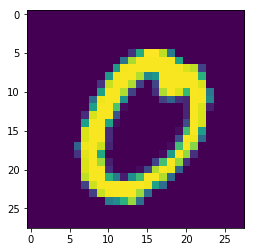

In [88]:
# look at an original image
plt.imshow(images[0,0].numpy())

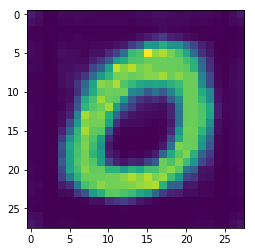

In [89]:
# run same image through autoencoder and take a peak
z_reps = encoder(images)
decoded_images = decoder(z_reps)

plt.imshow(decoded_images[0,0].detach().numpy())

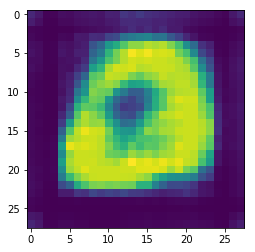

In [95]:
# try a random sample of the latent space
rand_z_reps = torch.randn_like(z_reps)
rand_decoded_images = decoder(rand_z_reps)

plt.imshow(rand_decoded_images[0,0].detach().numpy())